In [1]:
# %%
import sys
import os
import numpy as np
import math
import pickle
from itertools import product
from concurrent.futures import ProcessPoolExecutor
import matplotlib.pyplot as plt
import multiprocessing


os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
module_path = os.path.abspath(
    os.path.join(
        "/Users/lukasvoss/Documents/Master Wirtschaftsphysik/Masterarbeit Yale-NUS CQT/Quantum_Optimal_Control"
    )
)
if module_path not in sys.path:
    sys.path.append(module_path)

from correlated_noise_q_env_config import (
    q_env_config as gate_q_env_config,
    circuit_context,
    circuit_gate_times,
)
    
from correlated_noise_q_env_config_function import setup_quantum_environment

from quantumenvironment import QuantumEnvironment
from context_aware_quantum_environment import ContextAwareQuantumEnvironment
from hyperparameter_optimization_ressource_constraint import HyperparameterOptimizer
from gymnasium.spaces import Box
from gymnasium.wrappers import RescaleAction, ClipAction
from helper_functions import get_baseline_fid_from_phi_gamma, load_from_yaml_file
from ppo_while_not_met_baseline import make_train_ppo


import logging

logging.basicConfig(
    level=logging.WARNING,
    format="%(asctime)s INFO %(message)s",  # hardcoded INFO level
    datefmt="%Y-%m-%d %H:%M:%S",
    stream=sys.stdout,
)

# %%
def get_total_runtime_hpo(phis, gammas, max_runtime_per_trial, num_hpo_trials):
    return len(phis) * len(gammas) * max_runtime_per_trial * num_hpo_trials

# %%
def scale_action_space(phi_gamma_tuple, initial_phi=np.pi, initial_gamma=0.05, initial_space=Box(-0.1, 0.1, (7,), np.float32)):
    
    phi, gamma = phi_gamma_tuple
    
    # Calculate the initial and new ratios
    initial_ratio = initial_phi * initial_gamma
    new_ratio = phi * gamma

    # Scale the action space based on the ratio
    scale_factor = new_ratio / initial_ratio
    new_low = initial_space.low * scale_factor
    new_high = initial_space.high * scale_factor

    # Create a new action space with the scaled values
    new_space = Box(new_low, new_high, initial_space.shape, initial_space.dtype)

    return new_space

/Users/lukasvoss/Documents/Master Wirtschaftsphysik/Masterarbeit Yale-NUS CQT/Quantum_Optimal_Control/venv_qiskit10/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



 NoiseModel: Ideal 

Circuit context
     ┌─────────────────────────────┐     
q_0: ┤0                            ├──■──
     │  custom_kron(rx,ident)_gate │┌─┴─┐
q_1: ┤1                            ├┤ X ├
     └─────────────────────────────┘└───┘


In [2]:
target_fidelities = [0.999, 0.9999, 0.99999]

In [49]:
def get_min_N_REPS(target_fidelities, baseline_fidelity):
    return math.ceil(math.log(min(target_fidelities), baseline_fidelity))

In [3]:
phi_gamma_tuple = (np.pi/4, 0.02)
baseline_fidelity = get_baseline_fid_from_phi_gamma(phi_gamma_tuple)

n_reps = math.ceil(math.log(min(target_fidelities), c))

print(f'Phi = {phi_gamma_tuple[0]/np.pi}pi and gamma = {phi_gamma_tuple[1]}', '\nBaseline Fidelity:', baseline_fidelity, '\nNumber of Repetitions:', n_reps)

Phi = 0.25pi and gamma = 0.02 
Baseline Fidelity: 0.9999383162408302 
Number of Repetitions: 17


In [4]:
store_results = {}

In [5]:
for k in range(1, 3):
    store_results[k] = {}
    for seed in range(1, 6):

        gate_q_env_config, circuit_context, _ = setup_quantum_environment(phi_gamma_tuple=phi_gamma_tuple)
        # gate_q_env_config.action_space = scale_action_space(phi_gamma_tuple=phi_gamma_tuple)

        q_env = ContextAwareQuantumEnvironment(gate_q_env_config, circuit_context)
        q_env = ClipAction(q_env)
        q_env = RescaleAction(q_env, -1.0, 1.0)

        if k == 2:
            q_env.unwrapped.n_reps = n_reps

        path_agent_config = '/Users/lukasvoss/Documents/Master Wirtschaftsphysik/Masterarbeit Yale-NUS CQT/Quantum_Optimal_Control/template_configurations/agent_config.yaml' #os.path.join(os.path.dirname(grand_parent_dir), "agent_config.yaml")

        target_fidelities = [1.0-infid for infid in [1e-3, 1e-4, 1e-5]]

        max_runtime_per_trial = 600
        num_hpo_trials = 20
        lookback_window = 20

        agent_config = load_from_yaml_file(path_agent_config)

        train_agent = make_train_ppo(agent_config, q_env)

        training_results = train_agent(
            target_fidelities=target_fidelities, 
            lookback_window=lookback_window,
            max_runtime=max_runtime_per_trial,
            print_debug=False,
            num_prints=100
        )
        training_results['n_reps'] = q_env.unwrapped.n_reps

        store_results[k][seed] = training_results


Total Updates applied: 100
Total Shots applied: 12,176,640
Fidelity stored 0.9994787044426299
Sending Estimator job...
SparsePauliOp(['II', 'IZ', 'XY', 'YX', 'ZI', 'ZZ'],
              coeffs=[ 0.5       +0.j, -0.70710678+0.j,  0.70710678+0.j, -0.70710678+0.j,
  0.70710678+0.j, -0.5       +0.j])
Finished Estimator job
Total Updates applied: 101
Total Shots applied: 12,299,520
probabilities renormalized
Fidelity stored 0.9994792479987359
Sending Estimator job...
SparsePauliOp(['II', 'IZ', 'XY', 'YX', 'ZI', 'ZZ'],
              coeffs=[0.5       +0.j, 0.70710678+0.j, 0.70710678+0.j, 0.70710678+0.j,
 0.70710678+0.j, 0.5       +0.j])
Finished Estimator job
Total Updates applied: 102
Total Shots applied: 12,414,720
probabilities renormalized
Fidelity stored 0.9995645411844302
Sending Estimator job...
SparsePauliOp(['II', 'IZ', 'XY', 'YX', 'ZI', 'ZZ'],
              coeffs=[ 0.5       +0.j,  0.70710678+0.j,  0.70710678+0.j, -0.70710678+0.j,
 -0.70710678+0.j, -0.5       +0.j])
Finished Estima

In [6]:
with open('n_reps_results.pickle', 'wb') as f:
    pickle.dump(store_results, f)

### Analysis of Results

In [8]:
single_rep_results = store_results[1]
n_reps_results = store_results[2]

In [18]:
n_reps_results.keys()

dict_keys([1, 2, 3, 4, 5])

In [25]:
for seed in range(1, 6):
    single_rep_result = single_rep_results[seed]
    n_reps_result = n_reps_results[seed]

    print('Seed', seed)
    print(n_reps_result['fidelity_info'])

    

Seed 1
{0.999: {'achieved': True, 'update_at': 25, 'train_time': 101.92873811721802, 'shots_used': 3233280}, 0.9999: {'achieved': False, 'update_at': None, 'train_time': None, 'shots_used': None}, 0.99999: {'achieved': False, 'update_at': None, 'train_time': None, 'shots_used': None}}
Seed 2
{0.999: {'achieved': True, 'update_at': 29, 'train_time': 111.53043103218079, 'shots_used': 3290880}, 0.9999: {'achieved': False, 'update_at': None, 'train_time': None, 'shots_used': None}, 0.99999: {'achieved': False, 'update_at': None, 'train_time': None, 'shots_used': None}}
Seed 3
{0.999: {'achieved': True, 'update_at': 24, 'train_time': 94.12617087364197, 'shots_used': 2987520}, 0.9999: {'achieved': False, 'update_at': None, 'train_time': None, 'shots_used': None}, 0.99999: {'achieved': False, 'update_at': None, 'train_time': None, 'shots_used': None}}
Seed 4
{0.999: {'achieved': True, 'update_at': 24, 'train_time': 88.50807809829712, 'shots_used': 2676480}, 0.9999: {'achieved': True, 'update_

## NO down-scaling of the action space for smaller noise

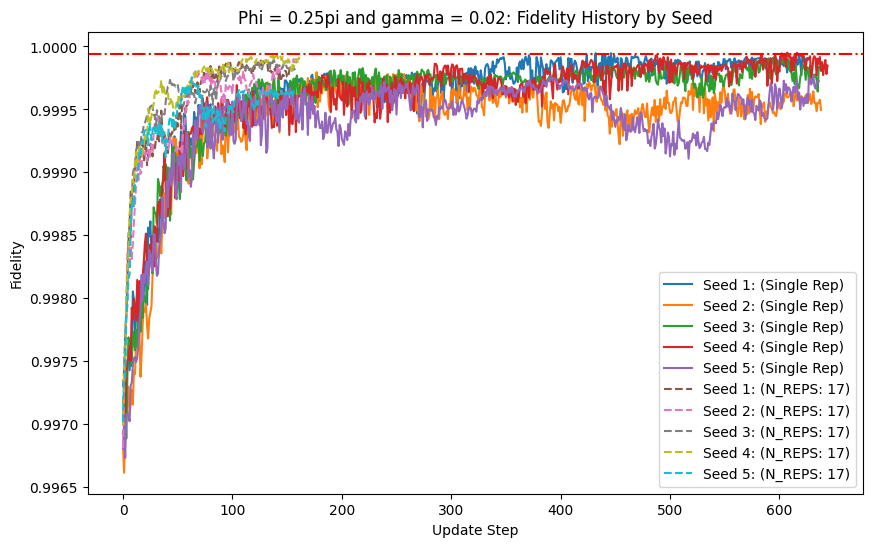

In [46]:
# Initialize the plot
plt.figure(figsize=(10, 6))

# Plot each seed's fidelity history from both dictionaries
for key, value in single_rep_results.items():
    plt.plot(value['fidelity_history'], label=f'Seed {key}: (Single Rep)')

for key, value in n_reps_results.items():
    plt.plot(value['fidelity_history'], label=f'Seed {key}: (N_REPS: {n_reps})', linestyle='--')

plt.axhline(y=baseline_fidelity, color='r', linestyle='-.')# Add titles and labels

plt.title(f'Phi = {phi_gamma_tuple[0]/np.pi}pi and gamma = {phi_gamma_tuple[1]}: Fidelity History by Seed')
plt.xlabel('Update Step')
plt.ylabel('Fidelity')
plt.legend()  # Add a legend to distinguish the lines


# Show the plot
plt.show()

#### Close Up to N_REPS

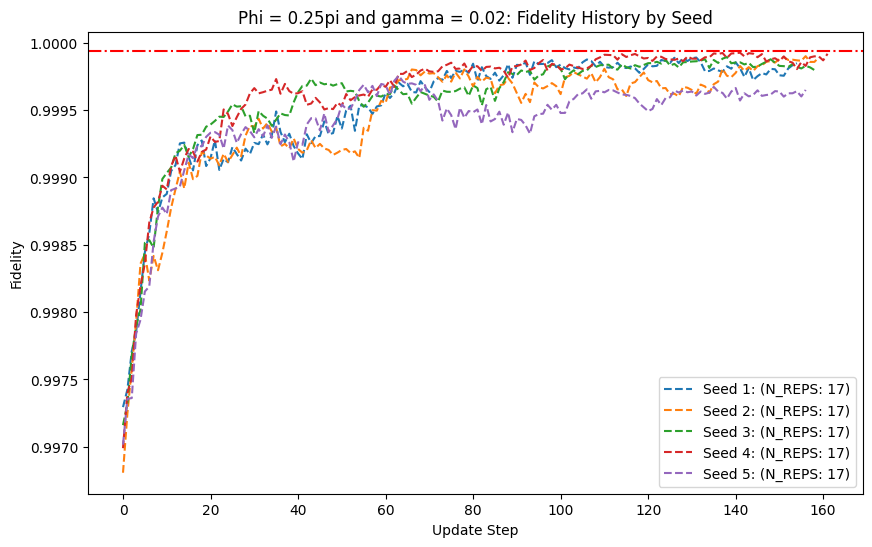

In [47]:
# Initialize the plot
plt.figure(figsize=(10, 6))

for key, value in n_reps_results.items():
    plt.plot(value['fidelity_history'], label=f'Seed {key}: (N_REPS: {n_reps})', linestyle='--')

plt.axhline(y=baseline_fidelity, color='r', linestyle='-.')# Add titles and labels

plt.title(f'Phi = {phi_gamma_tuple[0]/np.pi}pi and gamma = {phi_gamma_tuple[1]}: Fidelity History by Seed')
plt.xlabel('Update Step')
plt.ylabel('Fidelity')
plt.legend()  # Add a legend to distinguish the lines


# Show the plot
plt.show()

In [48]:
get_baseline_fid_from_phi_gamma((np.pi/4, 0.01))

0.9999845788223948

In [60]:
get_min_N_REPS(target_fidelities, get_baseline_fid_from_phi_gamma((np.pi/4, 0.02)))

17

#### Takeaway

- N_REPS offers an advantage by increasing sensitity for lower noise profiles
- Simulation time is higher >> possibly simulation time needs to be increased as well for the effect of N_REPS to fully come to power

#### Approach

- Do **not** scale down the action space for smaller noise gamma < 0.1; Only scale up action space for larger noise
- Increase the simulation time per trial for N_REPS > 1; max N_REPS for smallest noise is 65
- Run HPO with above settings 

#### Question

- Will for larger noise (and therefore larger total action space for all 7 parameters) the simulation time of 10mins be enough to shrink down the policy sufficiently to have high fidelities?
- Achieving 5 nines of accuracy (at least for single )